<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TOP" data-toc-modified-id="TOP-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TOP</a></span></li><li><span><a href="#Similarity-Network" data-toc-modified-id="Similarity-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Similarity Network</a></span></li><li><span><a href="#Generating-repairs" data-toc-modified-id="Generating-repairs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generating repairs</a></span></li><li><span><a href="#Optional:-Why-the-proposed-dd-in-the-other-paper-is-not-satisfactory-for-our-experiments" data-toc-modified-id="Optional:-Why-the-proposed-dd-in-the-other-paper-is-not-satisfactory-for-our-experiments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optional: Why the proposed dd in the other paper is not satisfactory for our experiments</a></span></li></ul></div>

We consider a Diferencial Dependency, (Address, City → Area Code,[0, 6],[0, 0],[0, 0]). Hence we construct a **similarity network** based on (Address, City) similarity and express Neighborhood constraints based on Area Code equality.

"""
Consider a relation
instance in Fig. 1c which collects customer information from
various sources. A dd (Address, City → Tel,[0, 6],[0, 0],
[0, 5]) states that if two tuples have similar Address values
(i.e., with distance1 in the range of [0, 6]) and the same City
values (with distance in [0, 0]), they should have similar Tel
values as well (distance within [0, 5]) by sharing the same
area code and another two digits for the same region. For
instance, tuples 1 and 2 of customers in the same street (of
the same city) have similar Tel numbers by sharing the same
prefix “0571-62”. Such dd rules can either be specified by
domain experts or discovered from data
"""

In [2]:
!pip install editdistance

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import os
import pandas as pd
import networkx as nx
import numpy as np
import editdistance
from igr import *

# TOP

In [4]:
df = pd.read_csv("data/restaurant/fz.csv")
df.head()

,name,addr,city,phone,type,class
0,arnie morton's of chicago,"""435 s. la cienega blv.""","""los angeles""","""310/246-1501""","""american""",'0'
1,arnie morton's of chicago,"""435 s. la cienega blvd.""","""los angeles""","""310-246-1501""","""steakhouses""",'0'
2,art's delicatessen,"""12224 ventura blvd.""","""studio city""","""818/762-1221""","""american""",'1'
3,art's deli,"""12224 ventura blvd.""","""studio city""","""818-762-1221""","""delis""",'1'
4,hotel bel-air,"""701 stone canyon rd.""","""bel air""","""310/472-1211""","""californian""",'2'


In [5]:
df["area_code"] = df["phone"].apply(lambda phone: phone[2:5])
df["area_code"]

0      310
1      310
2      818
3      818
4      310
      ... 
859    415
860    415
861    415
862    415
863    415
Name: area_code, Length: 864, dtype: object

In [6]:
df.describe()

,name,addr,city,phone,type,class,area_code
count,864,864,864,864,864,864,864
unique,776,772,49,857,84,752,11
top,arnie morton's of chicago,"""3570 las vegas blvd. s""","""new york""","""702/791-7111""","""american""",'0',212
freq,2,5,250,2,152,2,338


In [7]:
def string_dist(a,b):
    return editdistance.eval(a,b)

string_dist("str.", "street")

3

# Similarity Network


We consider a Diferencial Dependency, (Address, City → Area Code,[0, 6],[0, 0],[0, 0]). Hence we construct a **similarity network** based on (Address, City) similarity and express Neighborhood constraints based on Area Code equality.

**Instance Graph**
- nodes: every restaurant
- edges: if two restaurants have similar address and the same city
- node labels: the restaurant's area code

**Constraint Graph**
- nodes: area codes
- edges: self-edges

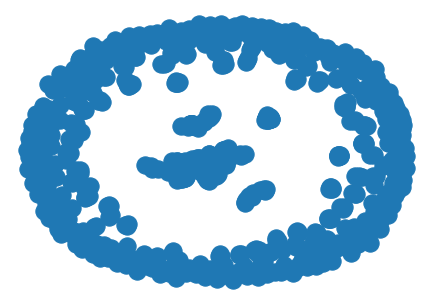

In [8]:
G_opt = nx.Graph()

for i,r in df.iterrows():
    G_opt.add_node(i)
    G_opt.nodes[i]['label'] = r["area_code"]
    G_opt.nodes[i]['addr'] = r["addr"]
    G_opt.nodes[i]['city'] = r["city"]
    for n in G_opt.nodes:
        if(n == i):
            continue
        if string_dist(G_opt.nodes[n]['addr'], r["addr"]) < 7 and G_opt.nodes[n]['city'] == r['city']:
            G_opt.add_edge(i,n)
            
nx.draw(G_opt)

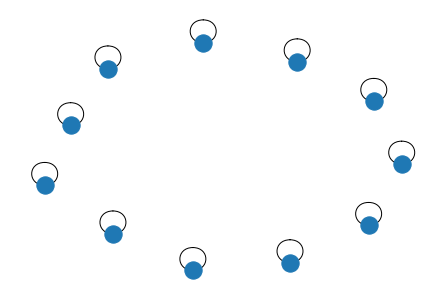

In [9]:
S = nx.Graph()

S.add_nodes_from(df["area_code"].unique()) 
S.add_edges_from(zip(S.nodes, S.nodes))

nx.draw(S)

In [13]:
violations(G_opt, S)[:5]

[(12, 244), (12, 260), (13, 244), (13, 260), (15, 41)]

We need a valid ground truth: we filter out the noisy cases in G_opt

In [14]:
i = 0
while len(violations(G_opt, S)) > 0:
    u,v = violations(G_opt, S)[0]
    G_opt.remove_node(u)
    i += 1
    
print("removed", i, "vertices to obtain a valid graph")

removed 18 vertices to obtain a valid graph


In [15]:
print( "|V| = ", len(G_opt.nodes))
print("|E|/|V| =", len(G_opt.edges) / len(G_opt.nodes))
print( "|L| = ", len(S.nodes))
print("|N|/|L| =", len(S.edges) / len(S.nodes))

|V| =  846
|E|/|V| = 6.1867612293144205
|L| =  11
|N|/|L| = 1.0


# Generating repairs

In [23]:
G_repaired = UserRepair(G.copy(),S,userRandom, *f_bool)

Warning: long run

In [19]:
x = []
for noise in [(0.08, 0.12), (0.18, 0.22), (0.27,0.33)]:
    for i in range(20):
        
        #inject noise
        G = force_inject_violations(G_opt, S, *noise)
        
        #generate repairs
        df = generate_all_repairs(G_opt, S, G, repair(G.copy(),S), steps=len(G)*2)
        df["noise"] = str(noise)
        
        x.append(df.copy())
        
df = pd.concat(x)
df

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

,G,S,G_opt,R,G',Answers,Q_difficulty,framework,user,noise
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[no, yes, no, yes, yes, yes, no, yes, no, no, ...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userRandom,"(0.08, 0.12)"
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...",None,"[(384, 818), (429, 818), (54, 818), delete, (5...","[(2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3...",gree,userRandom,"(0.08, 0.12)"
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...",None,"[(330, 718), (383, 818), (88, 770), (88, 415),...","[(2, 23), (2, 23), (2, 23), (2, 23), (2, 23), ...",perm,userRandom,"(0.08, 0.12)"
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[(330, 212), delete, delete, delete, (50, 212)...","[(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2...",term,userRandom,"(0.08, 0.12)"
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[yes, yes, delete, yes, delete, delete, delete...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userGreedy,"(0.08, 0.12)"
...,...,...,...,...,...,...,...,...,...,...
7,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[(66, 404), (384, 770), (66, 770), (130, 212),...","[(2, 3), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2...",term,userGreedy,"(0.27, 0.33)"
8,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[no, yes, yes, yes, no, yes, no, no, yes, no, ...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userOracle,"(0.27, 0.33)"
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[(66, 212), (340, 702), (130, 212), (384, 212)...","[(2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3...",gree,userOracle,"(0.27, 0.33)"
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[(66, 212), (384, 212), (130, 212), (104, 212)...","[(2, 23), (2, 23), (2, 23), (2, 23), (2, 23), ...",perm,userOracle,"(0.27, 0.33)"


In [20]:
df

,G,S,G_opt,R,G',Answers,Q_difficulty,framework,user,noise
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[no, yes, no, yes, yes, yes, no, yes, no, no, ...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userRandom,"(0.08, 0.12)"
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...",None,"[(384, 818), (429, 818), (54, 818), delete, (5...","[(2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3...",gree,userRandom,"(0.08, 0.12)"
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...",None,"[(330, 718), (383, 818), (88, 770), (88, 415),...","[(2, 23), (2, 23), (2, 23), (2, 23), (2, 23), ...",perm,userRandom,"(0.08, 0.12)"
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[(330, 212), delete, delete, delete, (50, 212)...","[(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2...",term,userRandom,"(0.08, 0.12)"
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[yes, yes, delete, yes, delete, delete, delete...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userGreedy,"(0.08, 0.12)"
...,...,...,...,...,...,...,...,...,...,...
7,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[(66, 404), (384, 770), (66, 770), (130, 212),...","[(2, 3), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2...",term,userGreedy,"(0.27, 0.33)"
8,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[no, yes, yes, yes, no, yes, no, no, yes, no, ...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userOracle,"(0.27, 0.33)"
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[(66, 212), (340, 702), (130, 212), (384, 212)...","[(2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3...",gree,userOracle,"(0.27, 0.33)"
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(310, 818, 213, 212, 718, 702, 404, 415, 770, ...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16,...","[(66, 212), (384, 212), (130, 212), (104, 212)...","[(2, 23), (2, 23), (2, 23), (2, 23), (2, 23), ...",perm,userOracle,"(0.27, 0.33)"


In [21]:
df.to_pickle("temp/restaurants_repairs.pickle")

# Optional: Why the proposed dd in the other paper is not satisfactory for our experiments

In [ ]:
G_opt = nx.Graph()

for i,r in df.iterrows():
    G_opt.add_node(i)
    G_opt.nodes[i]['label'] = r["area_code"]
    G_opt.nodes[i]['addr'] = r["addr"]
    G_opt.nodes[i]['name'] = r["name"]
    for n in G_opt.nodes:
        if(n == i):
            continue
        if string_dist(G_opt.nodes[n]['addr'], r["addr"]) < 7 and G_opt.nodes[n]['name'] == r['name']:
            G_opt.add_edge(i,n)
            
nx.draw(G_opt)

In [ ]:
2*len(G_opt.edges)/len(G_opt.nodes)

In [ ]:
len(G_opt.edges)

58 edges and 0.13 degree ==> there is nothing to repair or constrain